In [1]:
import os
import csv
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
OUTPUT_DIR = os.path.join('..', '..', 'processed')

In [3]:
def get_entity_type(entity_tag, exclude_inside=False):
    if entity_tag == 'O':
        return None

    if exclude_inside and entity_tag.startswith('I-'):
        return None

    splits = entity_tag.split('-')
    return (splits[0], splits[-1])

def calculate_dataset_statistics():
    entity_types_without_duplications = Counter()
    entity_types = Counter()
    sub_entity_types = {
        'gender': Counter(),
        'legal-status': Counter(),
        'role': Counter()
    }

    sub_entities_by_annotator = {}
    person_sub_entities = Counter()

    length_limit = 20
    long_annotations = []

    duplicated_words = []
    total_words = 0
    total_tags = 0
    current_annotator = ''
    current_document = ''

    entities_lengths = {}
    current_lengths = Counter()
    annotation_tokens = {}

    output_file = os.path.join(OUTPUT_DIR, 'train-nl.tsv')
    with open(output_file, 'r', encoding='utf-8', newline='') as file_handler:
        csv_reader = csv.DictReader(file_handler, fieldnames=['TOKEN', 'NE-MAIN', 'NE-PER-GENDER', 'NE-PER-LEGAL-STATUS', 'NE-PER-ROLE', 'MISC'], delimiter='\t')
        for i, row in enumerate(csv_reader):
            pos_type = None
            if i == 0:
                continue

            # skip all empty and commented lines
            if row['NE-MAIN'] == '':
                if row['TOKEN'].startswith('# annotator'):
                    current_annotator = row['TOKEN'].split('# annotator = ')[-1]

                if row['TOKEN'].startswith('# document'):
                    current_document = row['TOKEN'].split('# document = ')[-1]

                continue

            total_words += 1
            main_entity_types = [get_entity_type(x) for x in row['NE-MAIN'].split(',')]
            for main_entity_type_pair in main_entity_types:
                if main_entity_type_pair is None:
                    continue

                (pos_type, main_entity_type) = main_entity_type_pair

                if pos_type != 'I':
                    total_tags += 1
                    entity_types[main_entity_type] += 1

                sub_entity_count = 0

                if main_entity_type in current_lengths.keys():
                    if pos_type == 'B':
                        if main_entity_type not in entities_lengths.keys():
                            entities_lengths[main_entity_type] = []

                        current_length = current_lengths[main_entity_type]
                        if current_length >= length_limit:
                            long_annotations.append((current_document, current_length, main_entity_type, annotation_tokens[main_entity_type]))

                        entities_lengths[main_entity_type].append(current_length)
                        annotation_tokens[main_entity_type] = [row['TOKEN']]
                        current_lengths[main_entity_type] = 1
                    else:
                        annotation_tokens[main_entity_type].append(row['TOKEN'])
                        current_lengths[main_entity_type] += 1
                else:
                    current_lengths[main_entity_type] = 1
                    annotation_tokens[main_entity_type] = [row['TOKEN']]

            if pos_type is None or pos_type == 'I':
                continue

            gender = get_entity_type(row['NE-PER-GENDER'], exclude_inside=True)
            if gender is not None:
                sub_entity_types['gender'][gender[1]] += 1
                sub_entity_count += 1

            legal_status = get_entity_type(row['NE-PER-LEGAL-STATUS'], exclude_inside=True)
            if legal_status is not None:
                sub_entity_types['legal-status'][legal_status[1]] += 1
                sub_entity_count += 1

            role = get_entity_type(row['NE-PER-ROLE'], exclude_inside=True)
            if role is not None:
                sub_entity_types['role'][role[1]] += 1
                sub_entity_count += 1

            if 'Person' in [x[1] for x in main_entity_types if x is not None and x[0] == 'B']:
                person_sub_entities[sub_entity_count] += 1

                if current_annotator not in sub_entities_by_annotator.keys():
                    sub_entities_by_annotator[current_annotator] = Counter()

                sub_entities_by_annotator[current_annotator][sub_entity_count] += 1

        for entity_type, current_length in current_lengths.items():
            entities_lengths[entity_type].append(current_length)
            if current_length >= length_limit:
                long_annotations.append((current_document, current_length, entity_type, annotation_tokens[entity_type]))

    return entity_types_without_duplications, entity_types, sub_entity_types, duplicated_words, total_words, total_tags, person_sub_entities, sub_entities_by_annotator, entities_lengths, long_annotations

In [4]:
entity_types_without_duplications, entity_types, sub_entity_types, duplicated_words, total_words, total_tags, person_sub_entities, sub_entities_by_annotator, entities_lengths, long_annotations = calculate_dataset_statistics()

In [5]:
print(f'Total words: {total_words}')
print(f'Total tags: {total_tags}')
# print(f'Total duplications: {len(duplicated_words)}')
# print(f'Avg duplications: {np.mean(duplicated_words)}')

Total words: 311499
Total tags: 20111


In [6]:
def plot_pie_entity_types(entity_types, title, ax, explode=None):
        # Pie chart, where the slices will be ordered and plotted counter-clockwise:
        labels = list(entity_types.keys())
        sizes = list(entity_types.values())

        ax.pie(sizes, labels=labels, autopct='%1.1f%%', explode=explode,
                shadow=True, startangle=90)
        ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

        ax.set_title(title, fontweight='bold')

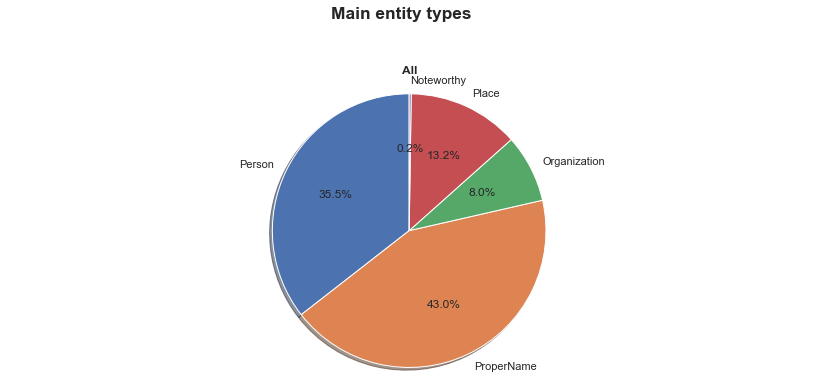

In [7]:
width = 6
fig, ax1 = plt.subplots(1, 1, figsize=(width*2,width))
fig.tight_layout(rect=[0, 0.03, 1, 0.85])

fig.suptitle('Main entity types', fontweight='bold', fontsize='x-large')

plot_pie_entity_types(entity_types, 'All', ax1)
# plot_pie_entity_types(entity_types_without_duplications, 'Without duplications', ax2)

plt.show()

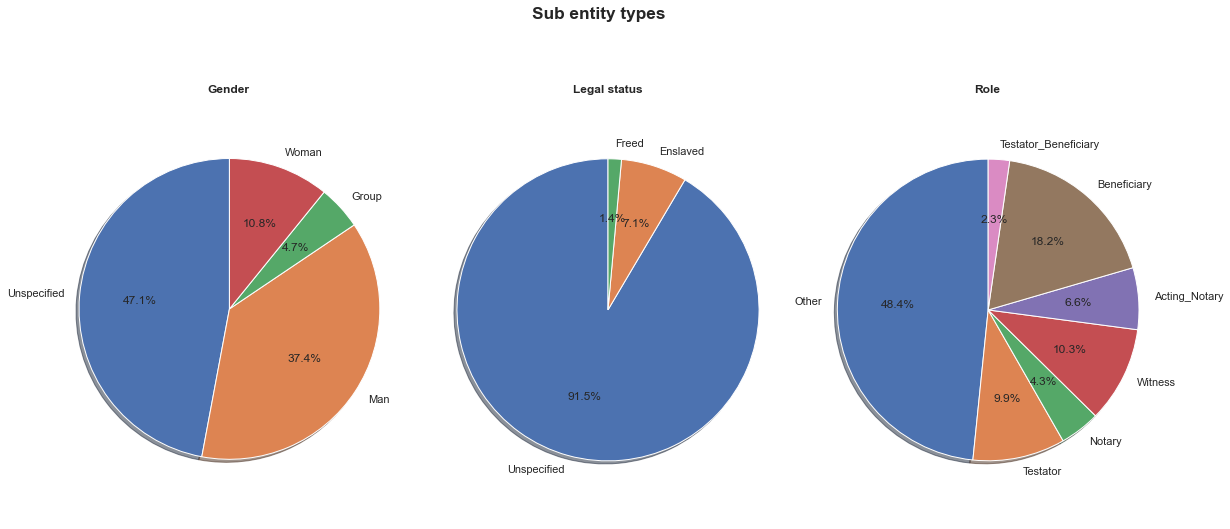

In [8]:
width = 8
fig, axes = plt.subplots(1, 3, figsize=(width*2,width))
fig.tight_layout(rect=[0, 0.03, 1, 0.85])

fig.suptitle('Sub entity types', fontweight='bold', fontsize='x-large')

for (type, values), ax in zip(sub_entity_types.items(), axes):
    user_friendly_type = type.replace('-', ' ').capitalize()
    plot_pie_entity_types(values, user_friendly_type, ax)

plt.show()

In [9]:
def print_sub_entity_counter(counter):
    total_elements = sum(list(counter.values()))
    percentages = {k: round((v / float(total_elements)) * 100, 2) for k, v in counter.items()}
    keys = sorted(list(counter.keys()))

    print('Person sub entities:')
    for key in keys:
        print(f'{key} -- Total: {counter[key]:5d}, Percentage: {percentages[key]:5.2f}%')

In [10]:
print_sub_entity_counter(person_sub_entities)

Person sub entities:
0 -- Total:     4, Percentage:  0.06%
1 -- Total:     9, Percentage:  0.13%
2 -- Total:   268, Percentage:  3.78%
3 -- Total:  6812, Percentage: 96.04%


In [11]:
for annotator, sub_entitities_counter in sub_entities_by_annotator.items():
    print(f'\n{annotator}: ')
    print_sub_entity_counter(sub_entitities_counter)


Bert: 
Person sub entities:
2 -- Total:    81, Percentage: 22.25%
3 -- Total:   283, Percentage: 77.75%

Emma: 
Person sub entities:
2 -- Total:     7, Percentage:  0.61%
3 -- Total:  1144, Percentage: 99.39%

Jonas: 
Person sub entities:
0 -- Total:     1, Percentage:  0.08%
1 -- Total:     8, Percentage:  0.67%
2 -- Total:   172, Percentage: 14.42%
3 -- Total:  1012, Percentage: 84.83%

Roos: 
Person sub entities:
0 -- Total:     1, Percentage:  0.05%
2 -- Total:     3, Percentage:  0.15%
3 -- Total:  2018, Percentage: 99.80%

Silja: 
Person sub entities:
0 -- Total:     2, Percentage:  0.16%
2 -- Total:     4, Percentage:  0.32%
3 -- Total:  1262, Percentage: 99.53%

Yolien: 
Person sub entities:
1 -- Total:     1, Percentage:  0.09%
2 -- Total:     1, Percentage:  0.09%
3 -- Total:  1093, Percentage: 99.82%


In [12]:
for key, values in entities_lengths.items():
    counter = Counter(values)
    print(f'{key}:')
    
    for k, v in sorted(counter.items()):
        print(f'  - length: {k:3d}, occurrences: {v:4d}')

ProperName:
  - length:   1, occurrences: 2645
  - length:   2, occurrences: 2672
  - length:   3, occurrences: 2107
  - length:   4, occurrences:  741
  - length:   5, occurrences:  222
  - length:   6, occurrences:  107
  - length:   7, occurrences:   46
  - length:   8, occurrences:   47
  - length:   9, occurrences:   31
  - length:  10, occurrences:   14
  - length:  11, occurrences:    6
  - length:  12, occurrences:    4
  - length:  13, occurrences:    2
  - length:  14, occurrences:    1
  - length:  15, occurrences:    1
  - length:  16, occurrences:    1
  - length:  17, occurrences:    1
  - length:  19, occurrences:    1
  - length:  22, occurrences:    1
  - length:  24, occurrences:    2
  - length:  27, occurrences:    1
  - length:  29, occurrences:    1
  - length:  39, occurrences:    1
Person:
  - length:   1, occurrences: 1009
  - length:   2, occurrences: 2032
  - length:   3, occurrences: 2007
  - length:   4, occurrences: 1001
  - length:   5, occurrences:  533


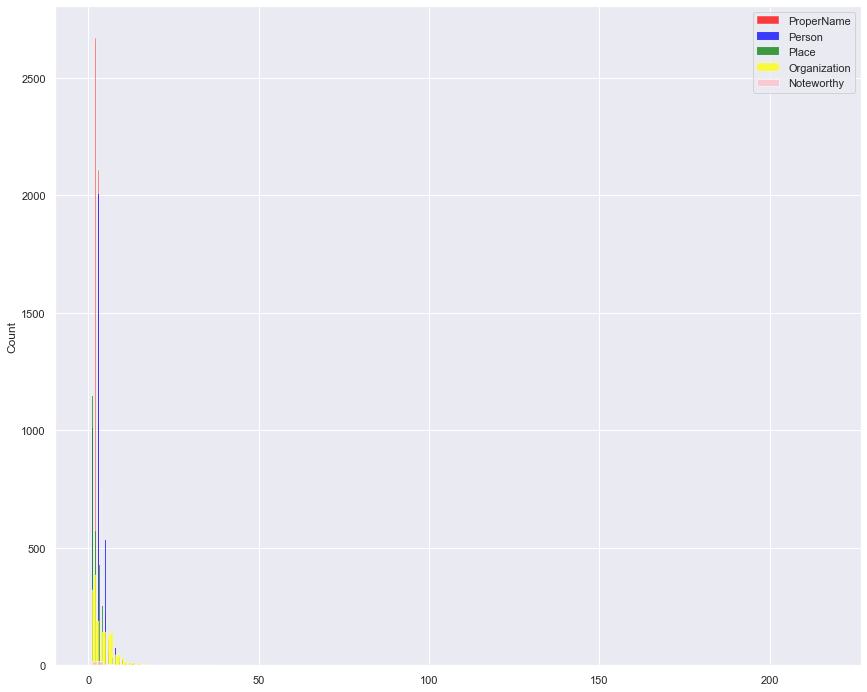

In [13]:
width = 12
fig, ax1 = plt.subplots(1, 1, figsize=(width,width))
fig.tight_layout(rect=[0, 0.03, 1, 0.85])

colors=['red','blue','green','yellow','pink']
for i, (key, values) in enumerate(entities_lengths.items()):
    sns.histplot(values, label=key, ax=ax1, color=colors[i])

plt.legend()

In [14]:
for path, length, entity, tokens in long_annotations:
    print(f'Path: "...{path[70:]}"\n - length: {length}\n - entity: {entity}\n - text: {" ".join(tokens)}')

Path: "...\data\Jonas\6853\NL-HaNA_1.04.02_6853_0149.txt"
 - length: 44
 - entity: Person
 - text: In den Name des Heeren Amen Ophuijden den 18 decemb„r 1744 des morgens de klokke half agtuuren Compareerde voor mij Abraham Abraham van van Dinter Dinter Notaris publijcq bij den Edelen Hose van Holland mitsgs d Edele Hoge regeeringe van Bed„s Johan Christoffel Swendel
Path: "...\data\Roos\6848\NL-HaNA_1.04.02_6848_0121.txt"
 - length: 23
 - entity: Person
 - text: Den Wel Edelen Gestrengen Heer Heer Bernardus Bernardus van van Pleuren Pleuren raad Ex tra ordnair van nederlands Jndia in Directeur van de
Path: "...\data\Roos\6848\NL-HaNA_1.04.02_6848_0124.txt"
 - length: 27
 - entity: Person
 - text: De wel Edele gestrenge Heeren Heeren Hendrik Hendrik van van Rockum Rockum raad Extra ordinair van neederlands India en President van t Eerwaarde Collegie van heeren weesmeesteren
Path: "...\data\Roos\6848\NL-HaNA_1.04.02_6848_0127.txt"
 - length: 216
 - entity: Person
 - text: uitgekeerd te w